# Lending Club Project

As a capstone for a Data Science course, I studied a subset of the LendingClub DataSet obtained from Kaggle: https://www.kaggle.com/wordsforthewise/lending-club

#### About LendingClub

LendingClub is a US peer-to-peer lending company, headquartered in San Francisco, California. It was the first peer-to-peer lender to register its offerings as securities with the Securities and Exchange Commission (SEC), and to offer loan trading on a secondary market. LendingClub is the world's largest peer-to-peer lending platform.

#### Our Goal

Given historical data on loans given out with information on whether or not the borrower defaulted (charge-off), can we build a model that can predict whether or nor a future borrower will pay back their loan? This way in the future when we get a new potential customer we can assess whether or not they are likely to pay back the loan. 

The "loan_status" column contains our label.


### Sections:
1. [Loading Packages and Files](#Loading-Packages-and-Files)
2. [Preprocessing](#Preprocessing) <br>
    2.1 [Missing Data](#Missing-Data) <br>
    2.2 [Categorical Variables](#Categorical-Variables) <br>
3. [Feature Selection](#Feature-Selection)
4. [Modeling](#Modeling) <br>
    4.1 [Grid Search](#Grid-Search) <br>
    4.2 [Neural Network](#Neural-Network)


## Loading Packages and Files

We start loading the following standard libraries:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

#for splitting training and test data
RANDOM_STATE = 14

Now we load the data:

In [2]:
#extract the data from RAR first
df = pd.read_csv(r'./DATA/lending_club_loan.csv')
# the df_info contains the information on this particular data set:
df_info = pd.read_csv(r'./DATA/lending_club_info.csv',index_col='LoanStatNew')

# for an easy access to the info
def feat_info(col_name):
    print(df_info.loc[col_name]['Description'])

Some basic info about our dataframe:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

We see that we have a few columns with missing data... We're going to tackle this problem shortly.

Before that, we are going to explore our data.

## Exploratory Data Analysis

First, let's see our target feature:

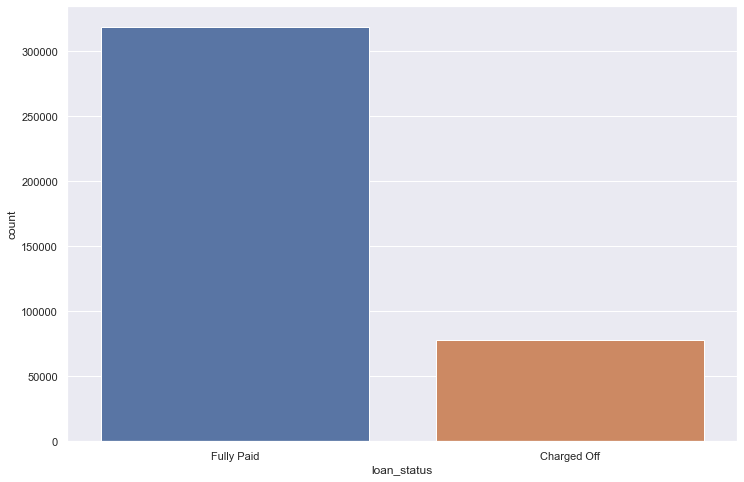

In [4]:
plt.figure(figsize=(12,8))
sns.countplot(df['loan_status'])

In [5]:
print('Percentage of Fully Paid loans: {:.2%}'.format((df[df['loan_status'] == 'Fully Paid'].shape[0])/(df.shape[0])))

Percentage of Fully Paid loans: 80.39%


We see that we have way more 'Fully Paid' labels than 'Charged Off' (80,39% to 19,61%). So whatever model we choose, we have to take this into account (since our model will probably be more 'biased' towards the 'Fully Paid' category)

Lets now explore the features of our dataset. Of all the columns, we start with the one that we think is the most correlated with our target: the 'Grade' column.

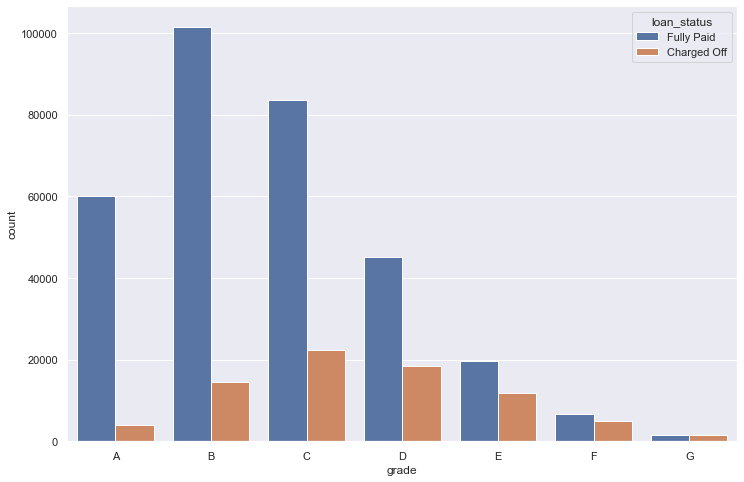

In [6]:
plt.figure(figsize=(12,8))
sns.countplot(x=df['grade'], order=sorted(df['grade'].unique()), hue=df['loan_status'])

We see that the grade seems to be well-correlated with the target variable: as the grade goes down, more defaults ('Charged Off') we have (proportionally).

Before we do another graph to attest our suspicions, let's see the distribution of sub-grades:

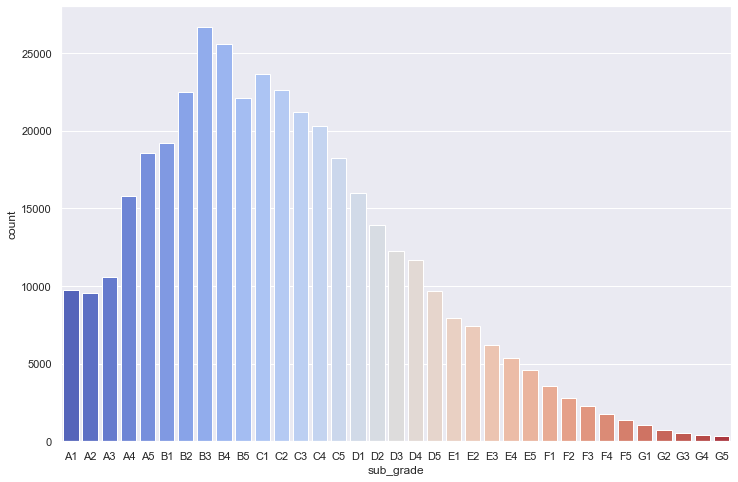

In [7]:
plt.figure(figsize=(12,8))
sns.countplot(x=df['sub_grade'],order = sorted(df['sub_grade'].unique()), palette='coolwarm')

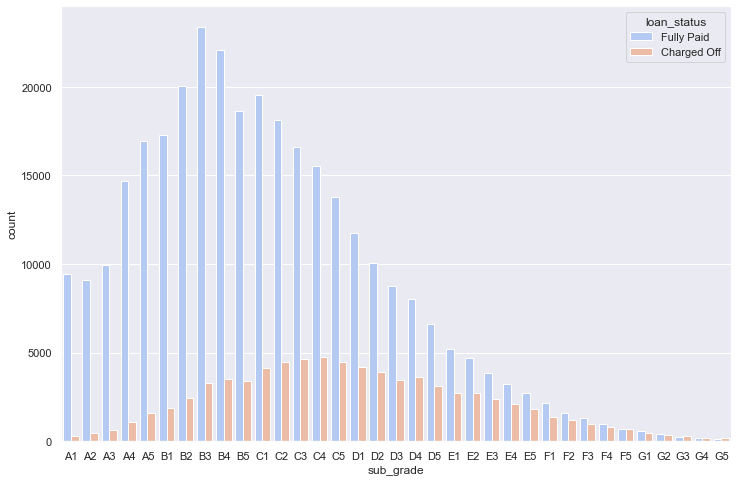

In [8]:
plt.figure(figsize=(12,8))
sns.countplot(x=df['sub_grade'],order = sorted(df['sub_grade'].unique()), hue=df['loan_status'], palette='coolwarm')

We see that the correlation between the target variable and the 'Sub-Grade' also exists (just like the 'Grade' variable and the target). That is not surprising at all, since the 'Sub-Grade' is a subset (in some sense) of the 'Grade' variable.

We now see the proportion of defaults per sub-grade:

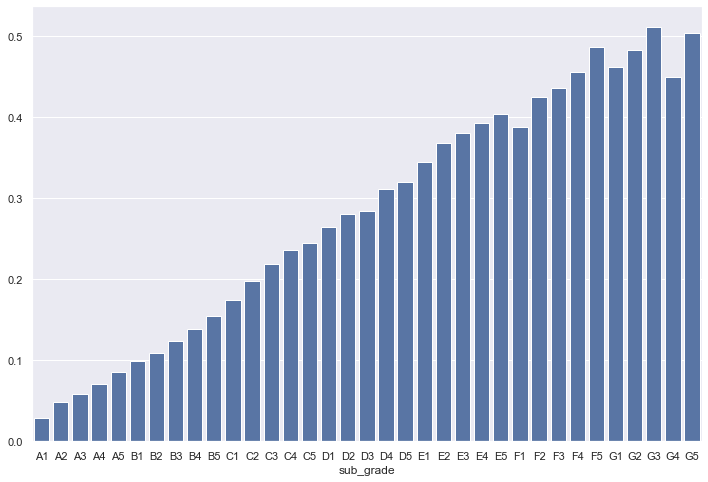

In [9]:
sub_g = df.groupby('sub_grade').count()['term']
sub_g_def = df[df['loan_status'] == 'Charged Off'].groupby('sub_grade').count()['term']

plt.figure(figsize=(12,8))
sns.barplot(x = (sub_g_def/sub_g).index, y = (sub_g_def/sub_g).values, color=sns.color_palette()[0])

We now clearly see how the defaults rise as the sub-grade goes down, confirming our suspicions.

Next, we look at the 'Loan Amount':

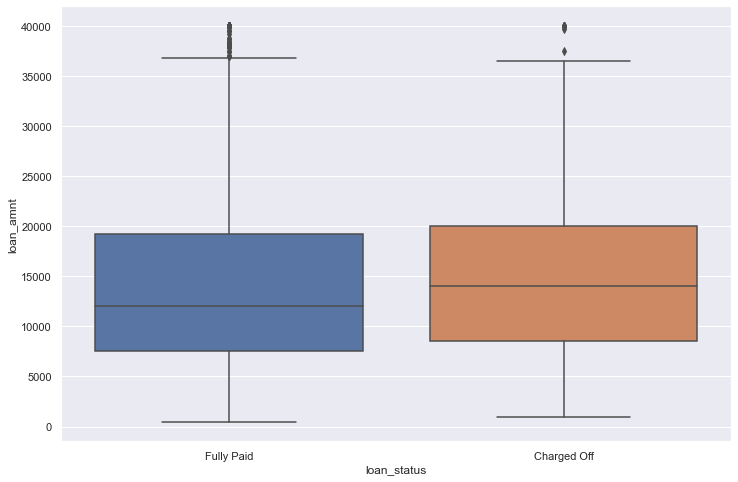

In [10]:
plt.figure(figsize=(12,8))
sns.boxplot(x='loan_status',y='loan_amnt',data=df)

We see that both categories have similar behaviour regarding the loan_amount - so it is likely that this feature is not well correlated.

Next we look at the Home Ownership:

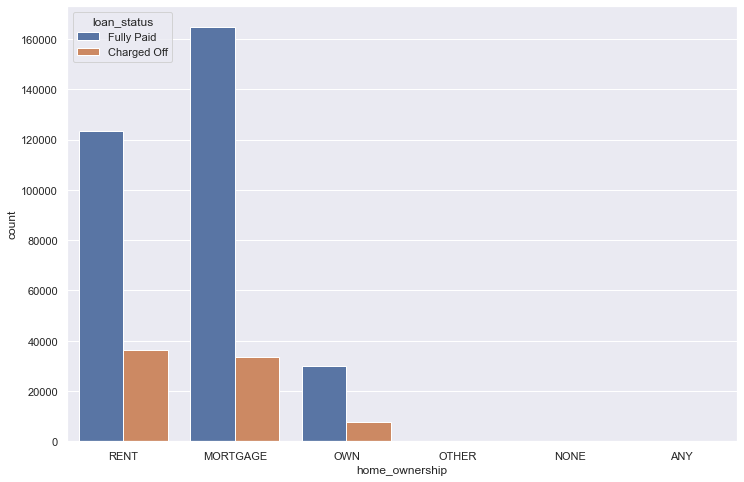

In [11]:
plt.figure(figsize=(12,8))
sns.countplot(x=df['home_ownership'], hue=df['loan_status'])

We notice that we have three categories that have very few data, so we'll probably look to join them all in a single one when we do our cleaning.

We cannot infer too much about the behaviour of our target with respect to the first three categories without doing some proportions. Since this is not our focus, we'll skip this.

Let's look now at the 'open_acc' column: a column which has the number of open credit lines in the borrower's credit file.

[Text(0, 0, '0.0'),
 Text(0, 0, '1.0'),
 Text(0, 0, '2.0'),
 Text(0, 0, '3.0'),
 Text(0, 0, '4.0'),
 Text(0, 0, '5.0'),
 Text(0, 0, '6.0'),
 Text(0, 0, '7.0'),
 Text(0, 0, '8.0'),
 Text(0, 0, '9.0'),
 Text(0, 0, '10.0'),
 Text(0, 0, '11.0'),
 Text(0, 0, '12.0'),
 Text(0, 0, '13.0'),
 Text(0, 0, '14.0'),
 Text(0, 0, '15.0'),
 Text(0, 0, '16.0'),
 Text(0, 0, '17.0'),
 Text(0, 0, '18.0'),
 Text(0, 0, '19.0'),
 Text(0, 0, '20.0'),
 Text(0, 0, '21.0'),
 Text(0, 0, '22.0'),
 Text(0, 0, '23.0'),
 Text(0, 0, '24.0'),
 Text(0, 0, '25.0'),
 Text(0, 0, '26.0'),
 Text(0, 0, '27.0'),
 Text(0, 0, '28.0'),
 Text(0, 0, '29.0'),
 Text(0, 0, '30.0'),
 Text(0, 0, '31.0'),
 Text(0, 0, '32.0'),
 Text(0, 0, '33.0'),
 Text(0, 0, '34.0'),
 Text(0, 0, '35.0'),
 Text(0, 0, '36.0'),
 Text(0, 0, '37.0'),
 Text(0, 0, '38.0'),
 Text(0, 0, '39.0'),
 Text(0, 0, '40.0'),
 Text(0, 0, '41.0'),
 Text(0, 0, '42.0'),
 Text(0, 0, '43.0'),
 Text(0, 0, '44.0'),
 Text(0, 0, '45.0'),
 Text(0, 0, '46.0'),
 Text(0, 0, '47.0'),
 T

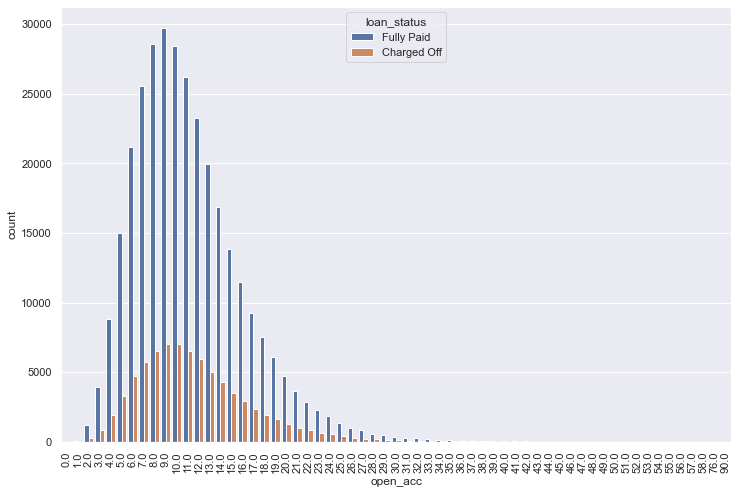

In [12]:
plt.figure(figsize=(12,8))
g = sns.countplot(x=df['open_acc'], hue=df['loan_status'])
g.set_xticklabels(g.get_xticklabels(), rotation = 90)

We see that we have a few outliers and probably the proportion is rising (as the 'open_acc' rises). Again, we'd need to make another graph to confirm this correlation - but we'll not make it.

Now, for employment length:

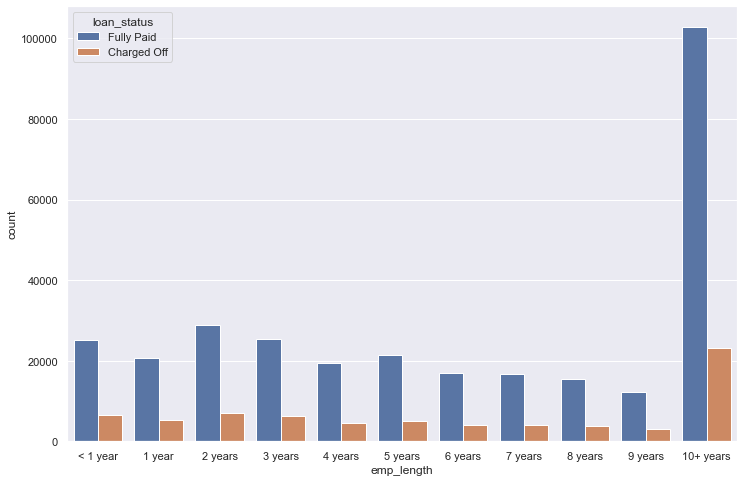

In [13]:
emp_order = ['< 1 year', '1 year'] + [str(num) + ' years' for num in range(2,10)] + ['10+ years']
plt.figure(figsize=(12,8))
sns.countplot(x=df['emp_length'], hue=df['loan_status'], order = emp_order)
plt.show()

We see that the proportions are mostly steady through each category; so this variable may not be useful at all.

At last, we look at the Annual Income together with Loan Amount:

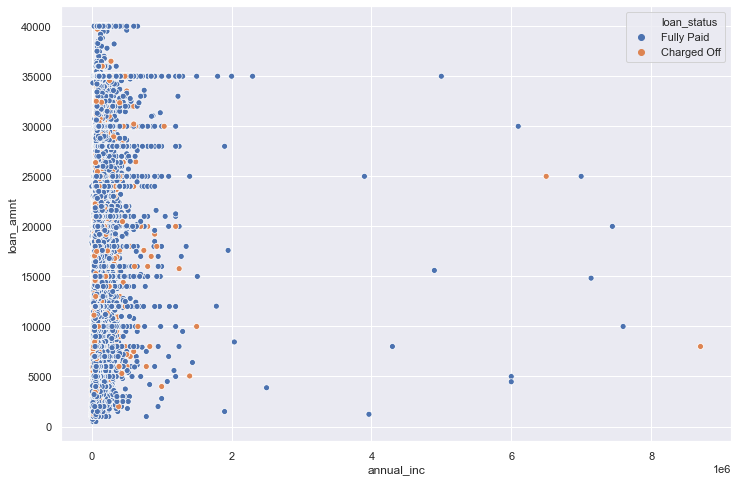

In [14]:
plt.figure(figsize=(12,8))
sns.scatterplot(x = df['annual_inc'], y=df['loan_amnt'], hue=df['loan_status'])

We see that we have a few outliers with income greater than 200k that are 'compressing' our data. The next box plot also shows this:

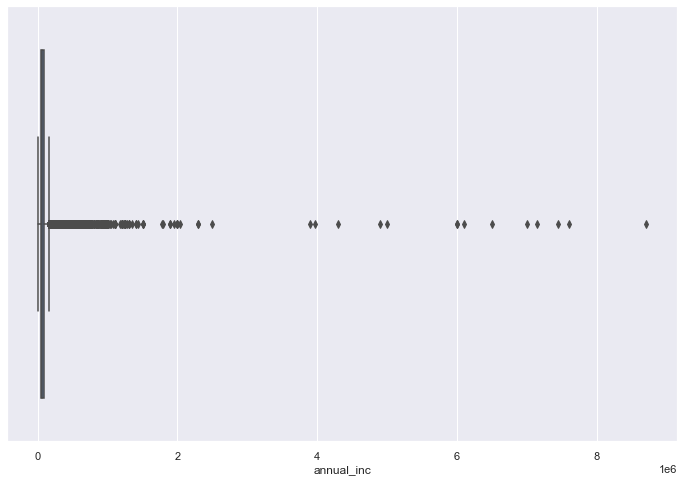

In [15]:
plt.figure(figsize=(12,8))
sns.boxplot(df['annual_inc']) 

Based on the box-plot above, we'll stablish a 'maximum' income and see if we can safely discard these outliers (that would obviously help our model perform better).

In [16]:
min_out_inc = 150000 #based on previous scatterplot with loan_amnt and the above boxplot
df_out = df[df['annual_inc'] >= min_out_inc]
print('Percentage of people with income greater than 150k: {:.2%}'.format(df_out.shape[0]/df.shape[0]))
df_out_default = df_out[df_out['loan_status'] == 'Charged Off']
print('Percentage of people with income greater than 150k that DIDN\'T payed their loan: {:.2%}'.format(df_out_default.shape[0]/df_out.shape[0]))

Percentage of people with income greater than 150k: 5.51%
Percentage of people with income greater than 150k that DIDN'T payed their loan: 14.21%


We see that those outliers are 5% of our data. We also see that amongst the people with an income greater than 150k, 14% defaulted their loan. This maybe seem to be too much, but it is 28,7% lower than the average for the people with an income lower than 150k (as seen below):

In [17]:
df_in = df[df['annual_inc'] < min_out_inc]
print('Percentage of people with income lower than 150k: {:.2%}'.format(df_in.shape[0]/df.shape[0]))
df_in_default = df_in[df_in['loan_status'] == 'Charged Off']
print('Percentage of people with income lower than 150k that DIDN\'T payed their loan: {:.2%}'.format(df_in_default.shape[0]/df_in.shape[0]))

Percentage of people with income lower than 150k: 94.49%
Percentage of people with income lower than 150k that DIDN'T payed their loan: 19.93%


After all, since they're so few (just 5%) and they have an average of defaults significantly lower than the rest of the population (which in turn can skew our model), we'll drop them.

After dropping, we'll plot the box plot again. Notice that the box plot shape is way better now.

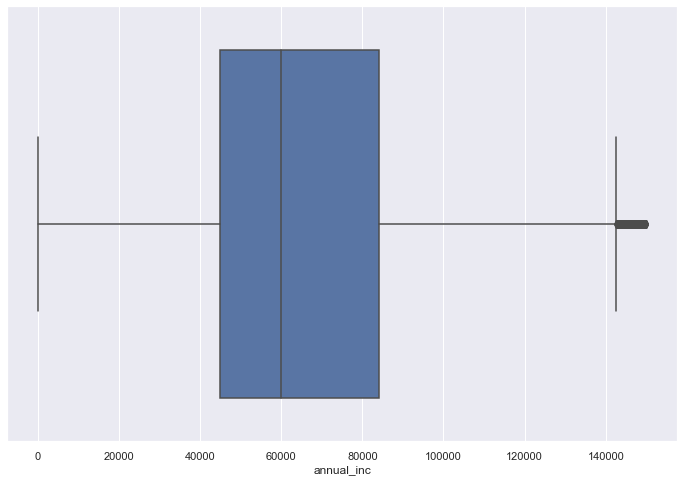

In [18]:
df = df[df['annual_inc'] < min_out_inc]
plt.figure(figsize=(12,8))
sns.boxplot(df['annual_inc']) #way more healthier

## Preprocessing

We'll now deal with missing data and the categorical variables.

### Missing Data

First, we look at which columns have missing data. Since we have over 300k entries, we'll look at the percentage of missing data:

In [19]:
(df.isnull().sum()/len(df))*100

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.879854
emp_length              4.832361
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.445452
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.064667
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                9.644146
pub_rec_bankruptcies    0.134945
address                 0.000000
dtype: float64

Since 'pub_rec_bankruptcies', 'revol_util' and 'title' have less than 1% each of missing data, we'll drop the respective entries in which the data is missing:

In [20]:
df = df.dropna(subset=['pub_rec_bankruptcies', 'revol_util','title'])
#again
(df.isnull().sum()/len(df))*100

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.849968
emp_length              4.804015
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.000000
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.000000
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                9.553971
pub_rec_bankruptcies    0.000000
address                 0.000000
dtype: float64

We'll now deal with 'mort_acc'. Per df_info, 'mort_acc' is the number of mortgage accounts of that client. We'll look at which other columns can help us fill the missing 10% data:

In [21]:
print(df.corr()['mort_acc'].sort_values())

int_rate               -0.079035
dti                    -0.015692
revol_util              0.003252
pub_rec                 0.018588
pub_rec_bankruptcies    0.038292
open_acc                0.097058
installment             0.169279
revol_bal               0.197287
loan_amnt               0.199588
annual_inc              0.328114
total_acc               0.370739
mort_acc                1.000000
Name: mort_acc, dtype: float64


Since 'total_acc' is the column in which 'mort_acc' is most correlated, we'll use this info to fill the 'mort_acc' column:

In [22]:
#Mean of mort_acc column per total_acc
total_acc_avg = df.groupby('total_acc').mean()['mort_acc']
total_acc_avg

total_acc
2.0      0.000000
3.0      0.053571
4.0      0.065728
5.0      0.100134
6.0      0.148899
           ...   
116.0    1.000000
117.0    0.000000
118.0    1.000000
124.0    1.000000
135.0    3.000000
Name: mort_acc, Length: 113, dtype: float64

In [23]:
def fill_mort_acc(total_acc,mort_acc):
    '''
    Accepts the total_acc and mort_acc values for the row.
    Checks if the mort_acc is NaN. If so, it returns the avg mort_acc value
    for the corresponding total_acc value for that row.
    
    total_acc_avg here should be a Series or dictionary containing the mapping of the
    groupby averages of mort_acc per total_acc values.
    '''
    if np.isnan(mort_acc):
        return total_acc_avg[total_acc]
    else:
        return mort_acc

df['mort_acc'] = df.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']), axis=1)

Having done this, let's check again which data is missing:

In [24]:
(df.isnull().sum()/len(df))*100

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.849968
emp_length              4.804015
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.000000
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.000000
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                0.000000
pub_rec_bankruptcies    0.000000
address                 0.000000
dtype: float64

We have 'emp_length' and 'emp_title' left. Since they're categorical, we'll deal with them together with our encodings.

### Categorical Variables

Now, we'll encode our categorical variables. We start with our target variable:

In [25]:
#LOAN_STATUS ---> TARGET VARIABLE AS A NUMERICAL
df['loan_status'].unique()
df['loan_status'] = df['loan_status'].map({'Fully Paid':1,'Charged Off':0})

Before going further (and messing even more the original dataframe), let's see all correlations with the target variable:

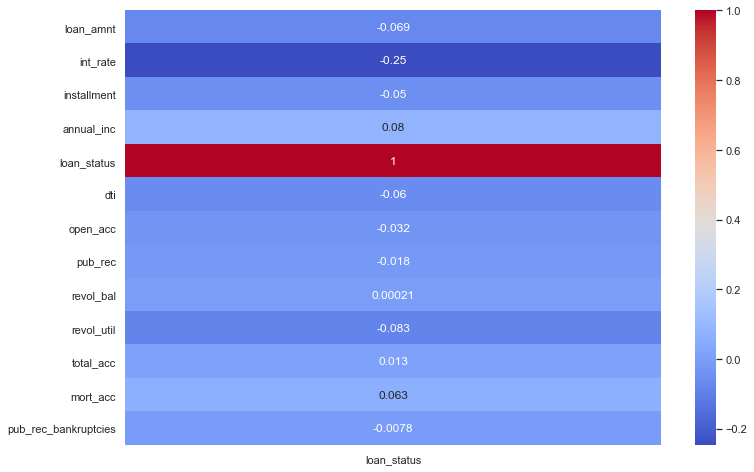

In [26]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr()['loan_status'].to_frame(), annot=True, cmap='coolwarm')

We see that the 'int_rate' (interest rate) feature is well correlated - which makes tons of sense. All the features that we thought would be well correlated in the EDA section are categorical, so we can't confirm our suspicions (yet).

Now, we will either do a label-encoding or a one-hot encoding in the categorical features. Since we have over 300k data (and most of the features we'll be encoding have few unique values) we'll do this **before** splitting our data. We note, however, that we chose to scale our data **after** splitting. 

Lastly, since we don't want to make this notebook too long (much more than already is), we'll explain our thought process in commentary code.

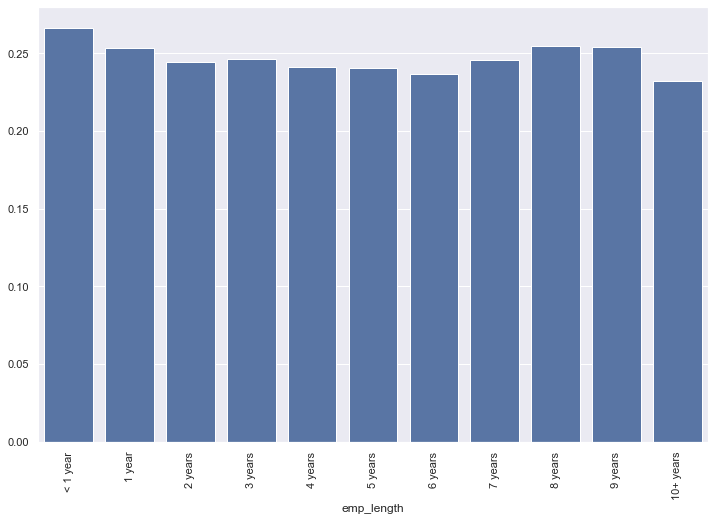

In [27]:
#TERM (per df_info: The number of payments on the loan. Values are in months and can be either 36 or 60.)
df['term'].describe()
uniques = list(df['term'].unique()) #36 months or 60 months.
#we do a manual label enconding:
df['term'] = df['term'].apply(lambda x : len(uniques) - uniques.index(x) - 1)

#GRADE
#is part of the sub-grade, so we'll drop it
df.drop('grade',axis=1, inplace=True)

#SUB-GRADE
df['sub_grade'].describe()
uniques = sorted(list(df['sub_grade'].unique()))
#since we have a 'order' of subgrades (with A1 being the best and G5 the worst), we also do a manual label encoding:
df['sub_grade'] = df['sub_grade'].apply(lambda x : len(uniques) - uniques.index(x) - 1)

#HOME-OWN
df['home_ownership'].describe()
uniques = list(df['home_ownership'].unique()) #any? other? 
#since no situation is 'better' than another, better do a one-hot enconding. 
#But first we're replacing 'ANY' and 'NONE' with 'OTHER'
df['home_ownership']=df['home_ownership'].replace(['NONE', 'ANY'], 'OTHER')
temp = pd.get_dummies(df['home_ownership'])
temp.drop(['OTHER'], inplace=True, axis=1)
df.drop('home_ownership', axis=1, inplace=True)
df = pd.concat([df, temp], axis=1)

#EMP_TITLE (still has missing data)
df['emp_title'].describe() #too many unique values, so we drop it
df.drop('emp_title', axis=1, inplace=True)

#EMP_LENGTH (still has missing data)
#lets see the proportion between years and paid/not paid
emp_co = df[df['loan_status']==0].groupby("emp_length").count()['loan_status']
emp_fp = df[df['loan_status']==1].groupby("emp_length").count()['loan_status']
emp_len = emp_co/emp_fp
plt.figure(figsize=(12,8))
g = sns.barplot(emp_len.index, emp_len.values, order=emp_order, color=sns.color_palette()[0])
g.set_xticklabels(g.get_xticklabels(), rotation = 90)
plt.show()

#since is so similar across all categories, lets drop it
df.drop('emp_length', axis=1, inplace=True)


#VERIFICATION_STATUS (per df_info: Indicates if income was verified by LC, not verified, or if the income source was verified)
df['verification_status'].describe()
uniques = list(df['verification_status'].unique())
#since not verified < source < verified, lets make a label enconding
df['verification_status'] = df['verification_status'].apply(lambda x : len(uniques) - uniques.index(x) - 1)


#PURPORSE (per df_info: A category provided by the borrower for the loan request.)
df['purpose'].describe()
uniques = list(df['purpose'].unique()) 
df.groupby('purpose').count()['int_rate'].sort_values(ascending=False)
#changing renewable_energy since has few occurences to home_improvement
df.loc[df['purpose'] == 'renewable_energy', 'purpose'] = 'home_improvement' 
#one-hot encoding
temp = pd.get_dummies(df['purpose'])
temp.drop('other', axis=1, inplace=True)
df.drop('purpose', axis=1, inplace=True)
df = pd.concat([df, temp], axis=1)

#TITLE (per df_info: The loan title provided by the borrower)
df['title'].describe() #too many unique values
#since we already have purpose, we are going to drop it
df.drop('title', axis=1, inplace=True)

#INITIAL_LIST_STATUS (per df_info: Interest Rate on the loan)
df['initial_list_status'].describe()
temp = pd.get_dummies(df['initial_list_status'], drop_first=True)
df.drop('initial_list_status', inplace=True, axis=1)
df = pd.concat([df, temp], axis=1)


#APPLICATION_TYPE (per df_info: Indicates whether the loan is an individual application or a joint application with two co-borrowers)
df['application_type'].describe()
temp = pd.get_dummies(df['application_type'], drop_first=True)
df.drop('application_type', inplace=True, axis=1)
df = pd.concat([df, temp], axis=1)

#ISSUE_D (per df_info: The month which the loan was funded)
#This would be data leakage, we wouldn't know beforehand whether or not a loan would be issued 
#when using our model, so in theory we wouldn't have an issue_date. So, we drop this feature.
df.drop('issue_d', inplace=True, axis=1)

#EARLIEST_CR_LINE (per df_info: The month the borrower's earliest reported credit line was opened)
date = pd.to_datetime(df['earliest_cr_line'])
#year
df['Earliest Credit Year'] = date.dt.year
#month as dummies
temp = pd.get_dummies(date.dt.month, drop_first=True)
df.drop('earliest_cr_line', inplace=True, axis=1)
df = pd.concat([df, temp], axis=1)


#ADDRESS
#getting only the zipcodes, since we only have 9 of them.
zipcodes = df['address'].apply(lambda x : x[-5:])
temp = pd.get_dummies(zipcodes, drop_first=True)
df.drop('address', inplace=True, axis=1)
df = pd.concat([df, temp], axis=1)


#REVOL_UTIL (per df_info: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.)
#This also may be data leakage depending on how the information is obtained: if it is when the client applies for the loan or after the loan is approved.
#We believe that is the former, so we won't drop this feature.
#Also, since it is a percentage of available credit, lets see if we have entries with more than 100%:
len(df[df['revol_util'] > 100]['revol_util'])/len(df)*100 #0.29% total
#since it is so few entries, lets work only with those lower than 100
df = df[df['revol_util'] < 100]


# checking if we still have missing data
miss_cols = [cols for cols in df.columns if df[cols].isnull().sum() > 0]

### SAVING TREATED DATA FOR EASIER FUTURE USE 
df.to_csv('lending_club_loan_treated.csv', index=False)

## Feature Selection

In [28]:
df.shape

(370695, 55)

Since we have now over 55 features, we'll do a feature selection to make our modelling faster. To avoid leakage, we'll first separate 20% of our data for 'production':

In [29]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)

In [30]:
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(score_func = f_classif, k=12)
X_train_sel = selector.fit_transform(X_train, y_train)

Let's see which features were chosen:

In [31]:
cols_selected = [name for index, name in enumerate(X.columns) if selector.get_support()[index]]
print(cols_selected)

['loan_amnt', 'term', 'int_rate', 'sub_grade', 'annual_inc', 'verification_status', 'revol_util', '05113', '11650', '29597', '86630', '93700']


Let's now visualize the scores:

[Text(0, 0, 'loan_amnt'),
 Text(0, 0, 'term'),
 Text(0, 0, 'int_rate'),
 Text(0, 0, 'installment'),
 Text(0, 0, 'sub_grade'),
 Text(0, 0, 'annual_inc'),
 Text(0, 0, 'verification_status'),
 Text(0, 0, 'dti'),
 Text(0, 0, 'open_acc'),
 Text(0, 0, 'pub_rec'),
 Text(0, 0, 'revol_bal'),
 Text(0, 0, 'revol_util'),
 Text(0, 0, 'total_acc'),
 Text(0, 0, 'mort_acc'),
 Text(0, 0, 'pub_rec_bankruptcies'),
 Text(0, 0, 'MORTGAGE'),
 Text(0, 0, 'OWN'),
 Text(0, 0, 'RENT'),
 Text(0, 0, 'car'),
 Text(0, 0, 'credit_card'),
 Text(0, 0, 'debt_consolidation'),
 Text(0, 0, 'educational'),
 Text(0, 0, 'home_improvement'),
 Text(0, 0, 'house'),
 Text(0, 0, 'major_purchase'),
 Text(0, 0, 'medical'),
 Text(0, 0, 'moving'),
 Text(0, 0, 'small_business'),
 Text(0, 0, 'vacation'),
 Text(0, 0, 'wedding'),
 Text(0, 0, 'w'),
 Text(0, 0, 'INDIVIDUAL'),
 Text(0, 0, 'JOINT'),
 Text(0, 0, 'Earliest Credit Year'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),

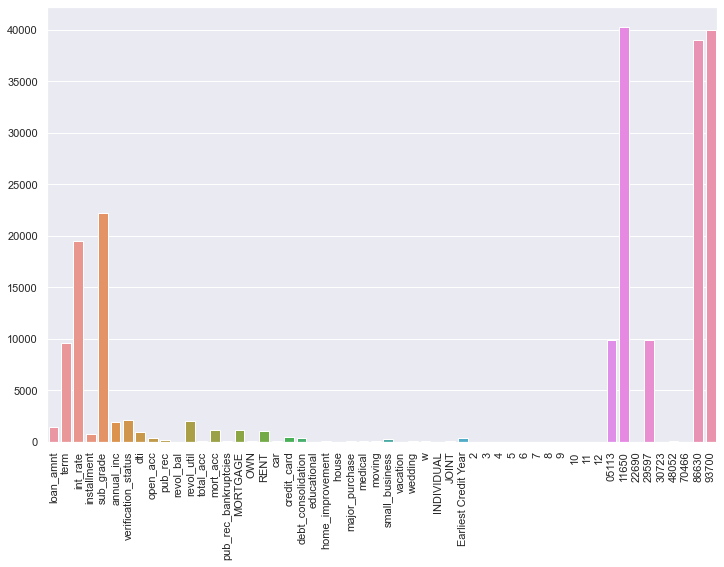

In [32]:
plt.figure(figsize=(12,8))
g = sns.barplot(x = X.columns, y = selector.scores_)
g.set_xticklabels(X.columns, rotation = 90)

We see that the 'sub-grade' and 'int_rate' are well-correlated features (just like we said in previous sections). Also, it seems like the zip-codes are important features.

With the features selected, we now train our models.

## Modeling

We'll use the most commons classification models and compare them.

First, we'll define our Cross-Validation method. As we saw in the first graph, we have much more 'Fully Paid' entries than 'Charged Off'. So, to deal with this, we will do a [*Stratified Suffle Split*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html).

In [33]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=RANDOM_STATE)

Now, we load the models:

In [34]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import SGDClassifier, Perceptron, LogisticRegression, RidgeClassifier, PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import LinearSVC
#not using non-linear SVC because it takes too much time to train 300k data

models = [LogisticRegression(), RandomForestClassifier(), AdaBoostClassifier(), BaggingClassifier(), 
         ExtraTreesClassifier(), GaussianNB(), SGDClassifier(), KNeighborsClassifier(n_neighbors = 2, n_jobs=-1), 
         DecisionTreeClassifier(), LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis(), XGBClassifier(), Perceptron(), BernoulliNB(), RidgeClassifier(), PassiveAggressiveClassifier(), LinearSVC()]

We now define a training function to train the data on each model from our list:

In [35]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import time

def training (model_list, sss, X_t, y_t):
    model_df = pd.DataFrame(columns=['Name', 'Accuracy Score (Mean)', 'Time'])
    row = 0        
    for model in model_list:
        pipe = Pipeline([('scaler', MinMaxScaler()), ('model', model)])
        print('Model ' + str(row+1) + ': ' + model.__class__.__name__)
        start = time.time()
        score = cross_val_score(pipe, X_t, y_t, cv = sss, scoring='accuracy')
        end = time.time()
        model_df.loc[row] = [model.__class__.__name__, np.mean(score), end-start]
        print(model.__class__.__name__ + ' registered')
        print('Time spent: {:.2f} \n'.format(end-start))
        row += 1
    
    return model_df

And now we do the training itself:

In [36]:
models_sss = training(models, sss, X_train_sel, y_train)
models_sss.sort_values('Accuracy Score (Mean)', ascending=False, inplace=True)
print(models_sss)

Model 1: LogisticRegression
LogisticRegression registered
Time spent: 8.03 

Model 2: RandomForestClassifier
RandomForestClassifier registered
Time spent: 161.03 

Model 3: AdaBoostClassifier
AdaBoostClassifier registered
Time spent: 46.74 

Model 4: BaggingClassifier
BaggingClassifier registered
Time spent: 43.29 

Model 5: ExtraTreesClassifier
ExtraTreesClassifier registered
Time spent: 127.23 

Model 6: GaussianNB
GaussianNB registered
Time spent: 1.52 

Model 7: SGDClassifier
SGDClassifier registered
Time spent: 2.67 

Model 8: KNeighborsClassifier
KNeighborsClassifier registered
Time spent: 269.37 

Model 9: DecisionTreeClassifier
DecisionTreeClassifier registered
Time spent: 7.86 

Model 10: LinearDiscriminantAnalysis
LinearDiscriminantAnalysis registered
Time spent: 3.01 

Model 11: QuadraticDiscriminantAnalysis


C:\Users\Andre\Documents\Spyder\WPy64-3830\python-3.8.3.amd64\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Andre\Documents\Spyder\WPy64-3830\python-3.8.3.amd64\lib\site-packages\sklearn\discriminant_analysis.py:740: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
C:\Users\Andre\Documents\Spyder\WPy64-3830\python-3.8.3.amd64\lib\site-packages\sklearn\discriminant_analysis.py:740: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
C:\Users\Andre\Documents\Spyder\WPy64-3830\python-3.8.3.amd64\lib\site-packages\sklearn\discriminant_analysis.py:743: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
C:\Users\Andre\Documents\Spyder\WPy64-3830\python-3.8.3.amd64\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
 

QuadraticDiscriminantAnalysis registered
Time spent: 1.86 

Model 12: XGBClassifier
XGBClassifier registered
Time spent: 24.81 

Model 13: Perceptron
Perceptron registered
Time spent: 2.15 

Model 14: BernoulliNB
BernoulliNB registered
Time spent: 1.52 

Model 15: RidgeClassifier
RidgeClassifier registered
Time spent: 1.52 

Model 16: PassiveAggressiveClassifier
PassiveAggressiveClassifier registered
Time spent: 2.33 

Model 17: LinearSVC
LinearSVC registered
Time spent: 20.16 

                             Name  Accuracy Score (Mean)        Time
5                      GaussianNB               0.886407    1.515088
6                   SGDClassifier               0.886407    2.667317
14                RidgeClassifier               0.886401    1.522345
9      LinearDiscriminantAnalysis               0.886378    3.014682
2              AdaBoostClassifier               0.886360   46.741848
13                    BernoulliNB               0.886351    1.524344
16                      LinearSVC

With the data from the models, we have ~10 models who perform (almost) equally. 

### Grid Search

Just for curiosity (and portfolio reasons), we'll now use GridSearchCV to tune the parameters of the Ridge Classifier (because is one of the fastest) and see if we can achieve a better score.

In [37]:
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([('scaler', MinMaxScaler()), ('rid', RidgeClassifier())])
grid = {'rid__alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'rid__solver': ['sag','lsqr', 'svd','cholesky']}

search = GridSearchCV(pipe, grid, scoring = 'accuracy', cv=sss, verbose=3)
search.fit(X_train_sel, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] rid__alpha=0.1, rid__solver=sag .................................
[CV] ..... rid__alpha=0.1, rid__solver=sag, score=0.886, total=   2.2s
[CV] rid__alpha=0.1, rid__solver=sag .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] ..... rid__alpha=0.1, rid__solver=sag, score=0.886, total=   2.1s
[CV] rid__alpha=0.1, rid__solver=sag .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s


[CV] ..... rid__alpha=0.1, rid__solver=sag, score=0.886, total=   2.3s
[CV] rid__alpha=0.1, rid__solver=sag .................................
[CV] ..... rid__alpha=0.1, rid__solver=sag, score=0.887, total=   1.7s
[CV] rid__alpha=0.1, rid__solver=sag .................................
[CV] ..... rid__alpha=0.1, rid__solver=sag, score=0.887, total=   2.3s
[CV] rid__alpha=0.1, rid__solver=lsqr ................................
[CV] .... rid__alpha=0.1, rid__solver=lsqr, score=0.886, total=   0.3s
[CV] rid__alpha=0.1, rid__solver=lsqr ................................
[CV] .... rid__alpha=0.1, rid__solver=lsqr, score=0.886, total=   0.3s
[CV] rid__alpha=0.1, rid__solver=lsqr ................................
[CV] .... rid__alpha=0.1, rid__solver=lsqr, score=0.886, total=   0.3s
[CV] rid__alpha=0.1, rid__solver=lsqr ................................
[CV] .... rid__alpha=0.1, rid__solver=lsqr, score=0.887, total=   0.3s
[CV] rid__alpha=0.1, rid__solver=lsqr ................................
[CV] .

[CV] ..... rid__alpha=0.4, rid__solver=sag, score=0.886, total=   2.2s
[CV] rid__alpha=0.4, rid__solver=sag .................................
[CV] ..... rid__alpha=0.4, rid__solver=sag, score=0.886, total=   2.1s
[CV] rid__alpha=0.4, rid__solver=sag .................................
[CV] ..... rid__alpha=0.4, rid__solver=sag, score=0.886, total=   1.9s
[CV] rid__alpha=0.4, rid__solver=sag .................................
[CV] ..... rid__alpha=0.4, rid__solver=sag, score=0.887, total=   2.2s
[CV] rid__alpha=0.4, rid__solver=sag .................................
[CV] ..... rid__alpha=0.4, rid__solver=sag, score=0.887, total=   1.9s
[CV] rid__alpha=0.4, rid__solver=lsqr ................................
[CV] .... rid__alpha=0.4, rid__solver=lsqr, score=0.886, total=   0.3s
[CV] rid__alpha=0.4, rid__solver=lsqr ................................
[CV] .... rid__alpha=0.4, rid__solver=lsqr, score=0.886, total=   0.3s
[CV] rid__alpha=0.4, rid__solver=lsqr ................................
[CV] .

[CV]  rid__alpha=0.6, rid__solver=cholesky, score=0.887, total=   0.2s
[CV] rid__alpha=0.6, rid__solver=cholesky ............................
[CV]  rid__alpha=0.6, rid__solver=cholesky, score=0.887, total=   0.2s
[CV] rid__alpha=0.7, rid__solver=sag .................................
[CV] ..... rid__alpha=0.7, rid__solver=sag, score=0.886, total=   1.9s
[CV] rid__alpha=0.7, rid__solver=sag .................................
[CV] ..... rid__alpha=0.7, rid__solver=sag, score=0.886, total=   1.8s
[CV] rid__alpha=0.7, rid__solver=sag .................................
[CV] ..... rid__alpha=0.7, rid__solver=sag, score=0.886, total=   1.8s
[CV] rid__alpha=0.7, rid__solver=sag .................................
[CV] ..... rid__alpha=0.7, rid__solver=sag, score=0.887, total=   1.9s
[CV] rid__alpha=0.7, rid__solver=sag .................................
[CV] ..... rid__alpha=0.7, rid__solver=sag, score=0.887, total=   2.1s
[CV] rid__alpha=0.7, rid__solver=lsqr ................................
[CV] .

[CV]  rid__alpha=0.9, rid__solver=cholesky, score=0.886, total=   0.2s
[CV] rid__alpha=0.9, rid__solver=cholesky ............................
[CV]  rid__alpha=0.9, rid__solver=cholesky, score=0.886, total=   0.2s
[CV] rid__alpha=0.9, rid__solver=cholesky ............................
[CV]  rid__alpha=0.9, rid__solver=cholesky, score=0.887, total=   0.2s
[CV] rid__alpha=0.9, rid__solver=cholesky ............................
[CV]  rid__alpha=0.9, rid__solver=cholesky, score=0.887, total=   0.2s
[CV] rid__alpha=1.0, rid__solver=sag .................................
[CV] ..... rid__alpha=1.0, rid__solver=sag, score=0.886, total=   1.8s
[CV] rid__alpha=1.0, rid__solver=sag .................................
[CV] ..... rid__alpha=1.0, rid__solver=sag, score=0.886, total=   1.7s
[CV] rid__alpha=1.0, rid__solver=sag .................................
[CV] ..... rid__alpha=1.0, rid__solver=sag, score=0.886, total=   1.7s
[CV] rid__alpha=1.0, rid__solver=sag .................................
[CV] .

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.3min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=14, test_size=0.3,
            train_size=None),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('rid', RidgeClassifier())]),
             param_grid={'rid__alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                        0.9, 1.0],
                         'rid__solver': ['sag', 'lsqr', 'svd', 'cholesky']},
             scoring='accuracy', verbose=3)

Checking the best parameters and the score:

In [38]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rid__alpha,param_rid__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.121480,0.214477,0.016204,4.004003e-04,0.1,sag,"{'rid__alpha': 0.1, 'rid__solver': 'sag'}",0.885913,0.886329,0.885744,0.886834,0.887183,0.886401,0.000543,1
1,0.280863,0.013139,0.018805,1.327603e-03,0.1,lsqr,"{'rid__alpha': 0.1, 'rid__solver': 'lsqr'}",0.885913,0.886329,0.885744,0.886834,0.887183,0.886401,0.000543,1
2,0.276445,0.004461,0.018705,7.480145e-04,0.1,svd,"{'rid__alpha': 0.1, 'rid__solver': 'svd'}",0.885913,0.886329,0.885744,0.886834,0.887183,0.886401,0.000543,1
3,0.195244,0.013321,0.018005,8.957493e-04,0.1,cholesky,"{'rid__alpha': 0.1, 'rid__solver': 'cholesky'}",0.885913,0.886329,0.885744,0.886834,0.887183,0.886401,0.000543,1
4,2.054513,0.040917,0.016004,4.909339e-07,0.2,sag,"{'rid__alpha': 0.2, 'rid__solver': 'sag'}",0.885913,0.886329,0.885744,0.886834,0.887183,0.886401,0.000543,1
5,0.266660,0.012013,0.017404,8.000612e-04,0.2,lsqr,"{'rid__alpha': 0.2, 'rid__solver': 'lsqr'}",0.885913,0.886329,0.885744,0.886834,0.887183,0.886401,0.000543,1
6,0.266461,0.009267,0.019604,2.871442e-03,0.2,svd,"{'rid__alpha': 0.2, 'rid__solver': 'svd'}",0.885913,0.886329,0.885744,0.886834,0.887183,0.886401,0.000543,1
7,0.192643,0.011502,0.017005,1.095801e-03,0.2,cholesky,"{'rid__alpha': 0.2, 'rid__solver': 'cholesky'}",0.885913,0.886329,0.885744,0.886834,0.887183,0.886401,0.000543,1
8,2.009655,0.100401,0.015804,4.002097e-04,0.3,sag,"{'rid__alpha': 0.3, 'rid__solver': 'sag'}",0.885913,0.886329,0.885744,0.886834,0.887183,0.886401,0.000543,1
9,0.272461,0.014168,0.018805,3.993750e-04,0.3,lsqr,"{'rid__alpha': 0.3, 'rid__solver': 'lsqr'}",0.885913,0.886329,0.885744,0.886834,0.887183,0.886401,0.000543,1


In the above dataframe we see that we didn't achieved much better results. In fact, the default values for the Ridge Classifier (alpha=1, solver=auto) had a score of 0.886401 (as we can see before the GridSearch), while our best score in the GridSearch was 0.886402 (as you can see below).

In [39]:
print(search.best_params_)
print(search.best_score_)

{'rid__alpha': 0.1, 'rid__solver': 'sag'}
0.8864005754942845


We now use the RidgeClassifier in 'production' with the parameters that we found (just for the sake of it, even though the accuracy gain is negligible):

In [40]:
#selecting the features for the test data based on our prior training data
X_test_sel = selector.transform(X_test)
#scaling the test data based on training data
scaler = MinMaxScaler()
X_train_sel = scaler.fit_transform(X_train_sel)
X_test_sel = scaler.transform(X_test_sel)

In [41]:
from sklearn.metrics import classification_report

clf = RidgeClassifier(alpha = 0.3, solver = 'lsqr')
clf.fit(X_train_sel, y_train)
preds = clf.predict(X_test_sel)

print('Classification Report: \n \n' + classification_report(y_test, preds))

Classification Report: 
 
              precision    recall  f1-score   support

           0       1.00      0.43      0.60     14668
           1       0.88      1.00      0.93     59471

    accuracy                           0.89     74139
   macro avg       0.94      0.71      0.77     74139
weighted avg       0.90      0.89      0.87     74139



So now, in production, our model performed well. Also, as expected, we had a **low recall score for the 0 category** (the 'Charged Off') since, as we pointed out in the beginning, we had way more data for the 1 category than the the 0 one.

Considering real-world applications, this model would be great in a **first analysis** since it has a 1.00 precision score for the zero category (i.e., if this model says the person will not pay the loan, then we have a high chance (nothing is 100%...) that it indeed won't pay). This model, however, couldn't find all the non-payers in the training (hence the low recall).

Now, just out of curiosity, let's use a Neural Network to see if we can obtain a model that is better at this metric. Also, we'll train the NN with all features.


### Neural Network

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape #54 columns, so we need 54 neurons in the first layer.

model = Sequential()
model.add(Dense(units=54,activation='relu'))
model.add(Dense(units=26,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)


### compile and fitting
## for a binary classification problem
model.compile(loss='binary_crossentropy', optimizer='adam')
model.fit(x=X_train, y=y_train, epochs=300, validation_data=(X_test, y_test), verbose=1, batch_size=256, callbacks=[early_stop])

Epoch 1/300
1159/1159 [==============================] - 1s 1ms/step - loss: 0.2923 - val_loss: 0.2651
Epoch 2/300
1159/1159 [==============================] - 1s 1ms/step - loss: 0.2644 - val_loss: 0.2634
Epoch 3/300
1159/1159 [==============================] - 1s 1ms/step - loss: 0.2632 - val_loss: 0.2623
Epoch 4/300
1159/1159 [==============================] - 1s 1ms/step - loss: 0.2621 - val_loss: 0.2627
Epoch 5/300
1159/1159 [==============================] - 1s 1ms/step - loss: 0.2618 - val_loss: 0.2612
Epoch 6/300
1159/1159 [==============================] - 1s 1ms/step - loss: 0.2611 - val_loss: 0.2603
Epoch 7/300
1159/1159 [==============================] - 1s 1ms/step - loss: 0.2606 - val_loss: 0.2599
Epoch 8/300
1159/1159 [==============================] - 1s 1ms/step - loss: 0.2603 - val_loss: 0.2632
Epoch 9/300
1159/1159 [==============================] - 1s 1ms/step - loss: 0.2603 - val_loss: 0.2607
Epoch 10/300
1159/1159 [==============================] - 1s 1ms/step - l

Lets see the history for the loss and val_loss.

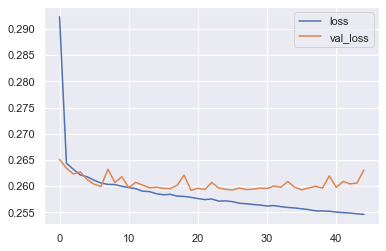

In [43]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

So we don't have a case for underfitting or overfitting. Let's now see the classification report:

In [46]:
preds = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.97      0.44      0.61     14668
           1       0.88      1.00      0.93     59471

    accuracy                           0.89     74139
   macro avg       0.92      0.72      0.77     74139
weighted avg       0.90      0.89      0.87     74139



Unfortunely, we didn't achieved a significantly better recall metric. In a real-life situation, we could search that *models* list that we trained earlier and find which models have a good recall score - and then use said model or even a [Voting Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html).